In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SEOP-and-NMR.git

# add path to .py files for import
import sys
sys.path.insert(1, "/content/SEOP-and-NMR/src")

Cloning into 'SEOP-and-NMR'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 324 (delta 164), reused 119 (delta 45), pack-reused 0
Receiving objects: 100% (324/324), 4.99 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [2]:
# PYTHON PACKAGES
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import inv
import matplotlib.pyplot as plt
import copy as cp
np.random.seed(14)

# MY PACKAGES
import physical_constant_units as phy
import environment as env
import xenon as xe
import utils

# Single specie simulation without magnetic noise

In this simulation we assume there is no magnetic noise and no effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


### Single specie simulation for sigmoid like world rotation

0.01
19999
| Xenon129 Environment:
| ----------
| B0:                     0.0001
| B_noise:                -0.0
| ωd_x:                   0.0
| Ωd_x:                   0.0
| ωd_y:                   -7440.6900000000005
| Ωd_y:                   0.12909944487358055
| Ωr:                     0.0
| Xenon 129:
| ----------
| gyromagnetic ratio:     -74406900.0
| T1:                     30
| T2:                     8
| K0:                     [0.0259 0.02   0.3   ]
| Kt:                     [0. 0. 0.]
| K steady:               [0. 0. 0.]


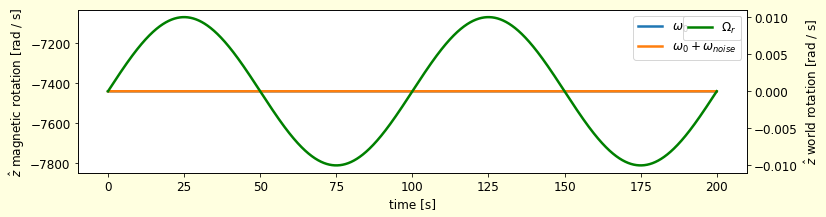

In [52]:
# solver parameters
freq = 0.01                     # [Hz]
period = 1 / freq               # [s]
num_periods = 2
t_final = num_periods * period  # [s]
dt = period / 10000              # [s]
print(dt)

steps = int(t_final // dt)
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)
print(steps)

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s     
#wr = 0.01 * utils.sigmoid(ts, 1, 100)                          # rad / s   
#wr = utils.ReLU(ts, x0=100, m=0.001)                          # rad / s

wr = 0.01 * np.sin(2 * np.pi * freq * ts)             # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
t2 = 8                                 # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = 0 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s


# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()
Xe129.set_bloch_matrix(env129)
Xe129.init_with_steady_state()



# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()

# # plot world rotation
# fig = plt.figure(figsize=(18, 8))
# ax2 = plt.subplot()
# ax2.plot(ts, wr, '.', label='$\Omega_r$', color='green')
# ax2.set_ylabel('$\hat{z}$ world rotation [rad / s]')
# ax2.legend()
# plt.show()




### Solve and plot results

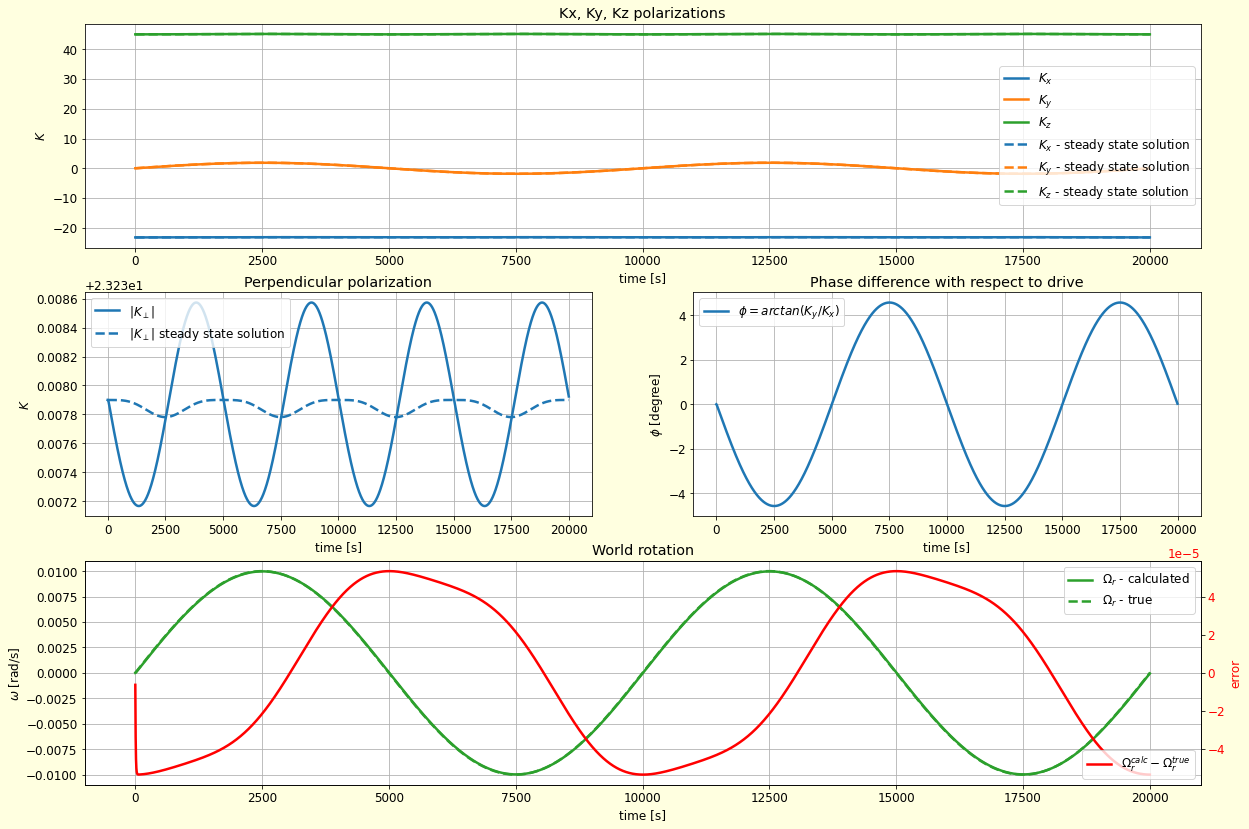

In [50]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)


### Bandwidth simulation

In [ ]:
freq_list = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1., 5, 10.])
phase_diff = np.zeros_like(freq_list)
apmlitude_ratio = np.zeros_like(freq_list)

for i, f in enumerate(freq_list):
  # solver parameters
  freq = f                        # [Hz]
  period = 1 / freq               # [s]
  num_periods = 2
  t_final = num_periods * period  # [s]
  dt = period / 1000              # [s]
  steps = int(t_final // dt)
  ts1 = np.linspace(0, dt, 2)
  ts = np.linspace(0, t_final, steps)

  # world rotation 
  wr = 0.01 * np.sin(2 * np.pi * freq * ts)             # rad / s

  # Xenon parameters
  g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
  t1 = 30                                # s
  t2 = 8                                 # s
  Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

  # Environment parameters
  B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
  Bnoise = 0 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
  Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
  wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
  Ad_x = np.zeros_like(ts)                                        # rad / s
  wd_x = np.zeros_like(ts)                                        # rad / s

  # initialize Environment
  env129 = env.Environment()
  env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
  env129.display_params()

  # initialize Xenon
  Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
  Xe129.set_spin_exchange_amp(Rse)
  Xe129.display_params()
  Xe129.set_bloch_matrix(env129)
  Xe129.init_with_steady_state()

  # run solver and save dynamics
  Xe129.solve_dynamics(env129)
  Xe129.compute_perpendicular_values()
    
  # computing the world rotation from xenon measurements
  world_rotation = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
  apmlitude_ratio[i] = world_rotation.max() / wr.max()
  phase_diff[i] = (np.argmax(world_rotation) - np.argmax(wr))





### Dynamic range simulation

In [ ]:
# world rotation parameters
wr_amplitude = np.logspace(-6, 2, 20)
wr_measurements = np.zeros_like(wr_amplitude)
errors = np.zeros_like(wr_amplitude)

# solver parameters
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# solver
for j in range(len(wr_amplitude)):
    # world rotation
    wr = wr_amplitude[j] * utils.sigmoid(ts, 1, 100)    # rad / s     
    
    # Xenon parameters
    g129 = phy.G129                        # [rad  s^-1  T^-1]
    t1 = 30                                # s
    t2 = 8                                 # s
    Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

    # Environment parameters
    B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
    Bnoise = 0 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
    Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
    wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
    Ad_x = np.zeros_like(ts)                                        # rad / s
    wd_x = np.zeros_like(ts)                                        # rad / s

    # initialize Xenon
    Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
    Xe129.set_spin_exchange_amp(Rse)

    # initialize Environment
    env129 = env.Environment()
    env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)

    # solving for each world rotation
    Xe129.solve_dynamics(env129)
    Xe129.compute_perpendicular_values()
    
    # computing the world rotation from xenon measurements
    world_rotation = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
    wr_measurements[j] = world_rotation[-1]

In [ ]:
# ploting the dynamic range
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.set_title('World rotation dynamic range simulation')
ax.loglog(wr_amplitude, wr_measurements, 'o', label='$\Omega_r$')
ax.loglog(wr_amplitude, wr_amplitude, label='linear')
ax.set_ylabel('$\Omega_r^{calc}$ [rad / s]')
ax.set_xlabel('$\Omega_r^{True}$ [rad / s]')
ax.vlines(1 / np.sqrt(t1 * t2), ymin=np.min(wr_measurements), ymax=np.max(wr_measurements), 
          color='red', label=r'$\frac{1}{\sqrt{T_1 * T_2}}$')
ax.grid(True)
ax.legend()
plt.tight_layout
plt.show()

So we see that without magnetic noise we can extract the world rotation from the xenon129 spin measurements as long as the rotation is not too strong $$\omega_r \leq \frac{1}{\sqrt{T_1 * T_2}}$$

# Single specie simulation with magnetic noise

In this simulation we generate magnetic noise and ignore the effective magnetic field of the alkali spin. Then, the phase of the Xenon with respect to the drive is given by

\begin{align}
    \phi_{129} &= -\frac{\gamma^{129}_{Xe}B_0}{\Gamma_2^{129}}-\frac{\gamma^{129}_{Xe}B_{noise}}{\Gamma_2^{129}}-\frac{\omega_r}{\Gamma_2^{129}}+\frac{\omega^{129}_{rf}}{\Gamma_2^{129}}
\end{align}


In [ ]:
# solver parameters
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# world rotation parameters
#wr = 30 * utils.gaussian(ts, 600, 40)                         # rad / s
wr = 0.01 * utils.sigmoid(ts, 1, 100)                          # rad / s

# Xenon parameters
g129 = phy.G129                        # gyromagnetic ratio [rad  s^-1  T^-1]
t1 = 30                                # s
t2 = 8                                 # s
Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

# Environment parameters
B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
Bnoise = 1e-6 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
Ad_x = np.zeros_like(ts)                                        # rad / s
wd_x = np.zeros_like(ts)                                        # rad / s

# initialize Xenon
Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
Xe129.set_spin_exchange_amp(Rse)
Xe129.display_params()

# initialize Environment
env129 = env.Environment()
env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)
env129.display_params()

# plot world rotation
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot()
ax.plot(ts, Xe129.gamma * B0, label='$\omega_0$')
ax.plot(ts, Xe129.gamma * (B0 + Bnoise), label='$\omega_0 + \omega_{noise}$')
ax.set_ylabel('$\hat{z}$ magnetic rotation [rad / s]')
ax.set_xlabel('time [s]')
ax.legend()
ax1 = ax.twinx()
ax1.plot(ts, wr, label='$\Omega_r$', color='green')
ax1.set_ylabel('$\hat{z}$ world rotation [rad / s]')
ax1.legend()
plt.show()


In [ ]:
# run solver and save dynamics
Xe129.solve_dynamics(env129)
Xe129.plot_results(env129)

In [ ]:
# world rotation parameters
wr_amplitude = np.logspace(-6, 2, 20)
wr_measurements = np.zeros_like(wr_amplitude)
errors = np.zeros_like(wr_amplitude)

# solver parameters
t_final = 500
dt = 1
steps = int(t_final // dt )
ts1 = np.linspace(0, dt, 2)
ts = np.linspace(0, t_final, steps)

# solver
for j in range(len(wr_amplitude)):
    # world rotation
    wr = wr_amplitude[j] * utils.sigmoid(ts, 1, 100)    # rad / s     
    
    # Xenon parameters
    g129 = phy.G129                        # [rad  s^-1  T^-1]
    t1 = 30                                # s
    t2 = 8                                 # s
    Rse = np.array([0, 0, 0.1]) * t1       # |K| / s

    # Environment parameters
    B0 = 1 * phy.G2T * np.ones_like(ts)                             # Tesla
    Bnoise = 1e-6 * phy.G2T * utils.smooth(np.random.randn(len(ts)))   # Tesla
    Ad_y = 2 * np.sqrt((1 / t1) * (1 / t2)) * np.ones_like(ts)      # rad / s
    wd_y = g129 * 1 * phy.G2T * np.ones_like(ts)                    # rad / s
    Ad_x = np.zeros_like(ts)                                        # rad / s
    wd_x = np.zeros_like(ts)                                        # rad / s

    # initialize Xenon
    Xe129 = xe.Xenon(gamma=g129, t1=t1, t2=t2, K0=np.array([0.0259, 0.02, 0.3]), ts=t_final, dt=dt, name='129')
    Xe129.set_spin_exchange_amp(Rse)

    # initialize Environment
    env129 = env.Environment()
    env129.set_state(wr=wr, B0=B0, Bnoise=Bnoise, Ad_y=Ad_y, wd_y=wd_y, Ad_x=Ad_x, wd_x=wd_x)

    # solving for each world rotation
    Xe129.solve_dynamics(env129)
    Xe129.compute_perpendicular_values()

    # computing the world rotation from xenon measurements
    world_rotation = -Xe129.phase_perp * Xe129.gamma2 + Xe129.gamma * env129.B0 - env129.wd_y
    wr_measurements[j] = world_rotation[-1]

In [ ]:
# ploting the dynamic range
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.set_title('World rotation dynamic range simulation')
ax.loglog(wr_amplitude, wr_measurements, 'o', label='$\Omega_r$')
ax.loglog(wr_amplitude, wr_amplitude, label='linear')
ax.set_ylabel('$\Omega_r^{calc}$ [rad / s]')
ax.set_xlabel('$\Omega_r^{True}$ [rad / s]')
ax.vlines(1 / np.sqrt(t1 * t2), ymin=np.min(wr_measurements), ymax=np.max(wr_measurements), 
          color='red', label=r'$\frac{1}{\sqrt{T_1 * T_2}}$')
ax.grid(True)
ax.legend()
plt.tight_layout
plt.show()


So we see that with magnetic noise we can extract the world rotation from the xenon129 spin measurements as long as the rotation is not too strong and when the rotation spectral amplitudes are small enough so they do not map into the perpendicular phase computation.

In order to solve the problem of the magnetic noise we need to introduce another Xenon specie (131) so we can subtruct the magnetic noise. 